In [ ]:
import zipfile
import os

# Define the path to the uploaded zip file
zip_file_path = '/content/brain_tumor_dataset.zip'  # Replace with the actual path of your zip file
unzip_dir = '/content/brain_mri_dataset/'  # Directory where the dataset will be unzipped

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

# Verify that the files have been extracted
print("Files in dataset directory:")
print(os.listdir(unzip_dir))


Files in dataset directory:
['brain_tumor_dataset']


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with 'yes' and 'no' subdirectories.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = []
        self.labels = []

        # Load images and labels
        for label_dir in ['yes', 'no']:
            label_dir_path = os.path.join(root_dir, label_dir)
            for file_name in os.listdir(label_dir_path):
                if file_name.endswith(('.png', '.jpg', '.jpeg')):
                    self.image_files.append(os.path.join(label_dir_path, file_name))
                    self.labels.append(1 if label_dir == 'yes' else 0)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        image = Image.open(img_name).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

# Instantiate the dataset with the correct path
dataset_dir = '/content/brain_mri_dataset/brain_tumor_dataset'  # Path to the dataset
brain_tumor_dataset = BrainTumorDataset(root_dir=dataset_dir, transform=transform)

# Create a DataLoader to handle batching
dataloader = DataLoader(brain_tumor_dataset, batch_size=32, shuffle=True)

# Verify the dataset
images, labels = next(iter(dataloader))
print(f"Batch size: {images.shape}")
print(f"Labels: {labels}")


Batch size: torch.Size([32, 3, 224, 224])
Labels: tensor([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 1, 0])


In [ ]:
import torch.nn as nn
import torch.optim as optim

class SimpleANN(nn.Module):
    def __init__(self):
        super(SimpleANN, self).__init__()
        self.fc1 = nn.Linear(224*224*3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 224*224*3)  # Flatten the input tensor
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))
        return x

# Instantiate the model, loss function, and optimizer
ann_model = SimpleANN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ann_model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in dataloader:
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = ann_model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize the weights
        running_loss += loss.item()  # Accumulate the loss

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}")

print("Finished Training Custom ANN")


Epoch 1/10, Loss: 0.7667579650878906
Epoch 2/10, Loss: 0.7688538134098053
Epoch 3/10, Loss: 0.7601198156674703
Epoch 4/10, Loss: 0.771213710308075
Epoch 5/10, Loss: 0.7271871467431387
Epoch 6/10, Loss: 0.7060408492883047
Epoch 7/10, Loss: 0.7293800910313925
Epoch 8/10, Loss: 0.7274612486362457
Epoch 9/10, Loss: 0.7203340629736582
Epoch 10/10, Loss: 0.7203340530395508
Finished Training Custom ANN


In [ ]:
import torchvision.models as models

# Load the pre-trained Vgg-Net model
vgg_model = models.vgg16(pretrained=True)

# Freeze all layers in the network
for param in vgg_model.parameters():
    param.requires_grad = False

# Replace the last layer to match our dataset's classes
vgg_model.classifier[6] = nn.Linear(4096, 2)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_model.classifier[6].parameters(), lr=0.001)

# Training loop (similar to ANN)
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in dataloader:
        optimizer.zero_grad()
        outputs = vgg_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}")

print("Finished Training Vgg-Net")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:07<00:00, 72.9MB/s]


Epoch 1/10, Loss: 0.5905522604783376
Epoch 2/10, Loss: 0.4460412710905075
Epoch 3/10, Loss: 0.4134297768274943
Epoch 4/10, Loss: 0.3469228645165761
Epoch 5/10, Loss: 0.3012908175587654
Epoch 6/10, Loss: 0.38847382366657257
Epoch 7/10, Loss: 0.3125376949707667
Epoch 8/10, Loss: 0.2816883350412051
Epoch 9/10, Loss: 0.26520125567913055
Epoch 10/10, Loss: 0.28603216012318927
Finished Training Vgg-Net


In [ ]:
# Load the pre-trained Resnet model
resnet_model = models.resnet18(pretrained=True)

# Freeze all layers in the network
for param in resnet_model.parameters():
    param.requires_grad = False

# Replace the last layer to match our dataset's classes
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, 2)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet_model.fc.parameters(), lr=0.001)

# Training loop (similar to ANN)
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, labels in dataloader:
        optimizer.zero_grad()
        outputs = resnet_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader)}")

print("Finished Training Resnet")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s]


Epoch 1/10, Loss: 0.7404719889163971
Epoch 2/10, Loss: 0.5992533763249716
Epoch 3/10, Loss: 0.49437809487183887
Epoch 4/10, Loss: 0.44884438316027325
Epoch 5/10, Loss: 0.42304915686448413
Epoch 6/10, Loss: 0.32391637563705444
Epoch 7/10, Loss: 0.333817757666111
Epoch 8/10, Loss: 0.2751423592368762
Epoch 9/10, Loss: 0.26329617698987323
Epoch 10/10, Loss: 0.2619381497303645
Finished Training Resnet


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import numpy as np

def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_preds = []

    with torch.no_grad():  # Disable gradient calculation
        for images, labels in dataloader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.numpy())
            all_preds.extend(preds.numpy())

    all_labels = np.array(all_labels)
    all_preds = np.array(all_preds)

    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print("Confusion Matrix:")
    print(conf_matrix)

# Evaluate the Custom ANN model
print("Evaluating Custom ANN Model:")
evaluate_model(ann_model, dataloader)

# Evaluate the Vgg-Net model
print("\nEvaluating Vgg-Net Model:")
evaluate_model(vgg_model, dataloader)

# Evaluate the Resnet model
print("\nEvaluating Resnet Model:")
evaluate_model(resnet_model, dataloader)


Evaluating Custom ANN Model:
Accuracy: 0.5978
Precision: 0.8571
Recall: 0.2069
Confusion Matrix:
[[89  3]
 [69 18]]

Evaluating Vgg-Net Model:
Accuracy: 0.9441
Precision: 0.9231
Recall: 0.9655
Confusion Matrix:
[[85  7]
 [ 3 84]]

Evaluating Resnet Model:
Accuracy: 0.9441
Precision: 0.9140
Recall: 0.9770
Confusion Matrix:
[[84  8]
 [ 2 85]]


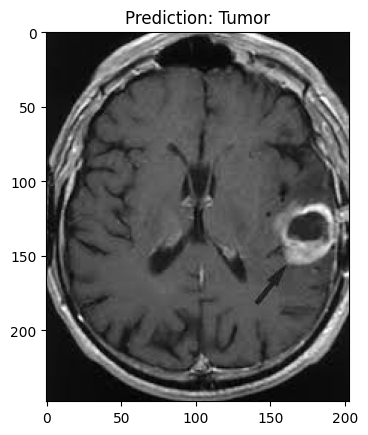

In [ ]:
import matplotlib.pyplot as plt

def predict_image(model, image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension

    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient computation
        output = model(image)
        _, predicted = torch.max(output, 1)

    return predicted.item()

def display_prediction(model, image_path):
    # Get the prediction
    prediction = predict_image(model, image_path)

    # Display the image and prediction
    plt.imshow(Image.open(image_path))
    plt.title(f"Prediction: {'Tumor' if prediction == 1 else 'No Tumor'}")
    plt.show()

# Example: Test the Resnet model on a new image
test_image_path = '/content/download (1).jpg'  # Replace with your image path
display_prediction(resnet_model, test_image_path)


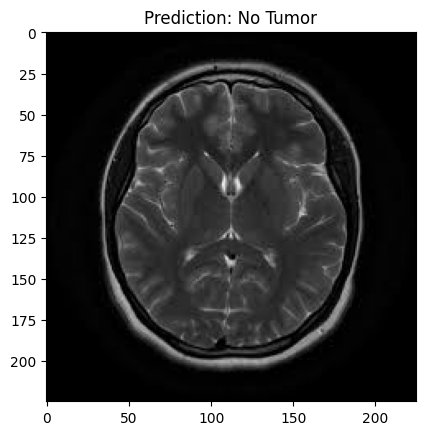

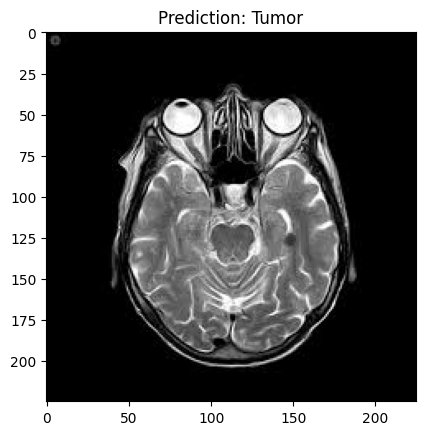

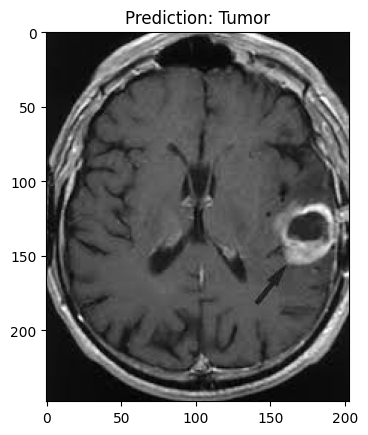

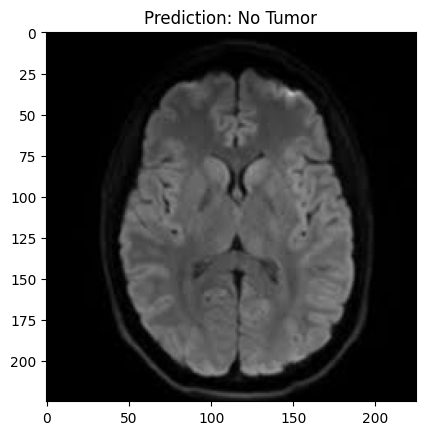

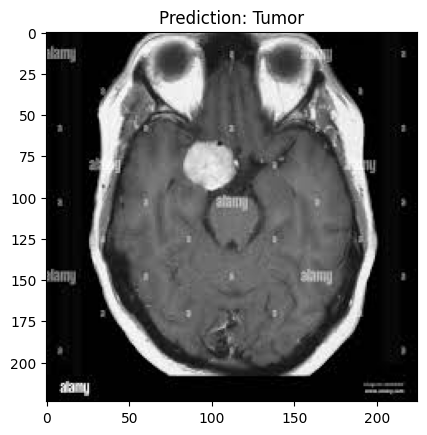

In [ ]:
test_image_paths = [
    '/content/download (3).jpg',  # Replace with actual paths
    '/content/download (4).jpg',
    '/content/download (1).jpg',
    "/content/download (5).jpg",
    "/content/download (6).jpg"
]

for image_path in test_image_paths:
    display_prediction(resnet_model, image_path)


In [ ]:
# Save the Resnet model
import torch

# Specify the path where you want to save the model
save_path = '/content/drive/MyDrive/resnet_brain_tumor_model.pth'  # Adjust the path as needed

# Save the model state dictionary
torch.save(resnet_model.state_dict(), save_path)

print(f"Model saved to {save_path}")


Model saved to /content/drive/MyDrive/resnet_brain_tumor_model.pth
